# Image Compression
### Comparison of JPEG and HiFiC

GitHub: https://github.com/pnagasam/dsc291_image_compression

#### Imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio as psnr
import os
import tfci

2022-06-09 12:21:31.426323: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-09 12:21:31.432027: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/nvidia/lib64:/usr/local/cuda/lib64
2022-06-09 12:21:31.432041: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Get metrics for JPEG

Uses OpenCV library to store images as JPEG at different bit rates (done by tuning the quality parameter in `cv2.imwrite()`. Takes average of the metrics mse, ssim, and pnsr metrics over`num_ims` number of images in `im_dir`.

In [9]:
im_dir = 'DIV2K_valid_HR'
im_store_dir_jpeg = 'jpeg_ims'

if not os.path.exists(im_store_dir_jpeg):
    os.mkdir(im_store_dir_jpeg)

im_name = '0{}.png'
num_ims = 5
start_ind = 801

im_jpg_name = 'store_jpg{}_{}.jpg'

In [10]:
qual_range = np.arange(0, 120, 20)

mse_jpg = np.zeros(qual_range.shape[0])
ssim_jpg = np.zeros(qual_range.shape[0])
psnr_jpg = np.zeros(qual_range.shape[0])

num_bytes = np.zeros(qual_range.shape[0])

for im_ind in range(start_ind,start_ind+num_ims):
    
    fp_read = os.path.join(im_dir, im_name.format(im_ind))
    im = cv2.imread(fp_read, cv2.IMREAD_COLOR)
    
    for q in range(len(qual_range)):
        qual = qual_range[q]
        fp_store = os.path.join(im_store_dir_jpeg, im_jpg_name.format(im_ind,qual))
        cv2.imwrite(fp_store, im, [int(cv2.IMWRITE_JPEG_QUALITY), qual])
        num_bytes[q] += os.path.getsize(fp_store)
        im_jpg = cv2.imread(fp_store)
        mse_jpg[q] += mean_squared_error(im, im_jpg)
        ssim_jpg[q] += ssim(im, im_jpg, data_range=im.max() - im.min(), multichannel=True)
        psnr_jpg[q] += psnr(im, im_jpg)
        
mse_jpg = mse_jpg/num_ims
ssim_jpg = ssim_jpg/num_ims
psnr_jpg = psnr_jpg/num_ims
num_bytes = num_bytes/num_ims

#### Plots for JPEG

Plotting the metrics at different JPEG compression bit rates

Text(0.5, 1.0, 'JPEG MSE vs bpp')

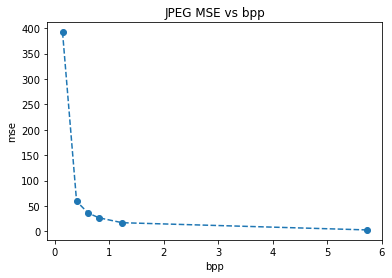

In [4]:
plt.plot(num_bytes*8/(im.shape[0]*im.shape[1]), mse_jpg, '--o')
plt.xlabel('bpp')
plt.ylabel('mse')
plt.title('JPEG MSE vs bpp')

Text(0.5, 1.0, 'JPEG SSIM vs bpp')

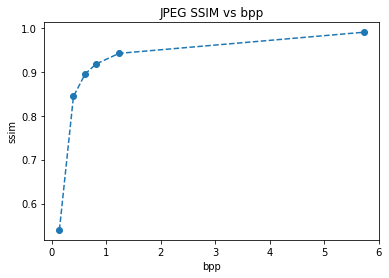

In [5]:
plt.plot(num_bytes*8/(im.shape[0]*im.shape[1]), ssim_jpg, '--o')
plt.xlabel('bpp')
plt.ylabel('ssim')
plt.title('JPEG SSIM vs bpp')

Text(0.5, 1.0, 'JPEG PSNR vs bpp')

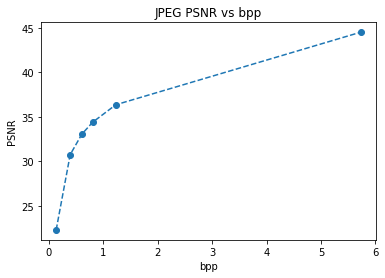

In [6]:
plt.plot(num_bytes*8/(im.shape[0]*im.shape[1]), psnr_jpg, '--o')
plt.xlabel('bpp')
plt.ylabel('PSNR')
plt.title('JPEG PSNR vs bpp')

#### Getting Metrics for HiFiC (SOTA)

Uses the `tfci` library imported above to compress/ decompress the images on a pre-trained HiFiC model.

In [3]:
num_ims = 1

start_ind = 801

im_dir = 'DIV2K_valid_HR'
im_store_dir_hific = "hific_ims"
im_store_decomp = "hific_ims_decomp"
im_name = '0{}.png'

im_hific_name = 'store_hific_{}_{}.tfci'

model_name = "hific-{}"
models = ["hi","mi","lo"]

im_decomp_name = 'decomp_{}_{}.png'

### WARNING: 
This cell takes a while to run (caused many kernel issues on our end) -- check hifi_ims and and hific_ims_decomp to check if there are already images in the directory and skip cell.

In [ ]:
if not os.path.exists(im_store_decomp):
    os.mkdir(im_store_decomp)
    
if not os.path.exists(im_store_dir_hific):
    os.mkdir(im_store_dir_hific)

for im_ind in range(start_ind,start_ind+num_ims):
    
    fp_read = os.path.join(im_dir, im_name.format(im_ind))
    im = cv2.imread(fp_read, cv2.IMREAD_COLOR)

    for model_ext in models:

        fp_out = os.path.join(im_store_dir_hific, im_hific_name.format(model_ext, start_ind))
        model = model_name.format(model_ext)
        fp_decomp = os.path.join(im_store_decomp, im_decomp_name.format(model_ext, start_ind))

        tfci.compress(model = model, input_file = fp_read, output_file = fp_out)
        tfci.decompress(input_file = fp_out, output_file = fp_decomp)

2022-06-09 12:18:19.308005: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/nvidia/lib64:/usr/local/cuda/lib64
2022-06-09 12:18:19.308124: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/nvidia/lib64:/usr/local/cuda/lib64
2022-06-09 12:18:19.308183: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.9/site-packages/cv2/../../lib64:/us

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [4]:
arr = []
mse_hific = []
ssim_hific = []
psnr_hifi = []

for im_ind in range(start_ind,start_ind+num_ims):
    
    fp_read = os.path.join(im_dir, im_name.format(im_ind))
    im = cv2.imread(fp_read, cv2.IMREAD_COLOR)
    
    for model_ext in models:
        
        fp_out = os.path.join(im_store_dir_hific, im_hific_name.format(model_ext, im_ind))
        fp_decomp = os.path.join(im_store_decomp, im_decomp_name.format(model_ext, im_ind))
        
        im_hific = cv2.imread(fp_decomp, cv2.IMREAD_COLOR)
        
        arr.append(os.path.getsize(fp_out)*8/(im.shape[0]*im.shape[1]))
        
        mse_hific.append(mean_squared_error(im, im_hific))
        ssim_hific.append(ssim(im, im_hific, data_range=im.max() - im.min(), multichannel=True))
        psnr_hifi.append(psnr(im, im_hific))

### Plots for HiFiC

Plotting the metrics (mse, ssim, and psnr) for HiFiC against bpp (bits per pixel)

#### MSE Plot
As shown below, as bpp increases, MSE decreases.

Text(0.5, 1.0, 'MSE of HiFiC vs bpp')

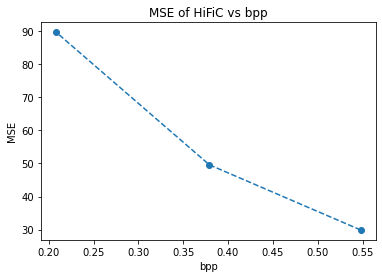

In [5]:
plt.plot(arr, mse_hific, '--o')
plt.xlabel('bpp')
plt.ylabel('MSE')
plt.title('MSE of HiFiC vs bpp')

#### SSIM Plot
As shown below, as bpp increases SSIM increases.

Text(0.5, 1.0, 'SSIM of HiFiC vs bpp')

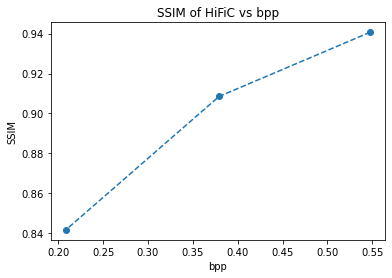

In [6]:
plt.plot(arr, ssim_hific, '--o')
plt.xlabel('bpp')
plt.ylabel('SSIM')
plt.title('SSIM of HiFiC vs bpp')

#### PSNR Plot
As shown below, as bpp increases PSNR increases.

Text(0.5, 1.0, 'PSNR of HiFiC vs bpp')

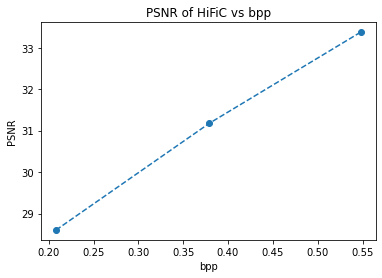

In [7]:
plt.plot(arr, psnr_hifi, '--o')
plt.xlabel('bpp')
plt.ylabel('PSNR')
plt.title('PSNR of HiFiC vs bpp')

#### Comparing JPEG and HFIC on the different Metrics

##### Plot comparing MSE of JPEG and HiFiC

As shown below HiFiC performs much worse than JPEG in terms of the MSE metric. This is expected as JPEG purely minimizes MSE however HiFiC takes into account other distortion metrics.

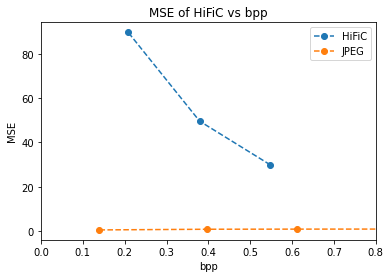

In [11]:
plt.plot(arr, mse_hific, '--o')
plt.xlabel('bpp')
plt.ylabel('MSE')
plt.title('MSE of HiFiC vs bpp')
plt.plot(num_bytes*8/(im.shape[0]*im.shape[1]), ssim_jpg, '--o')
plt.xlim([0,.8])
plt.legend(['HiFiC', 'JPEG'])

##### Plot comparing SSIM of JPEG and HiFiC

As shown below HiFiC performs better than JPEG in terms of the MSE metric. This is expected as HiFiC takes SSIM into account in its loss function where as JPEG is purely MSE. However as shown here it does not seem that HiFiC is drastically better even in these lower bit rates.

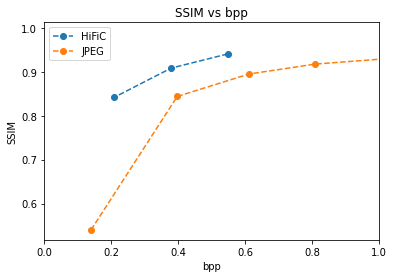

In [12]:
plt.plot(arr, ssim_hific, '--o')
plt.xlabel('bpp')
plt.ylabel('SSIM')
plt.title('SSIM vs bpp')
plt.plot(num_bytes*8/(im.shape[0]*im.shape[1]), ssim_jpg, '--o')
plt.xlim([0,1])
plt.legend(['HiFiC', 'JPEG'])

##### Plot comparing PNSR of JPEG and HiFiC

As shown below HiFiC performs slightly better than JPEG in terms of the MSE metric. Neither HiFiC nor JPEG take PSNR into account into their loss function ans so bothe perform approximately the same.

(0.0, 0.8)

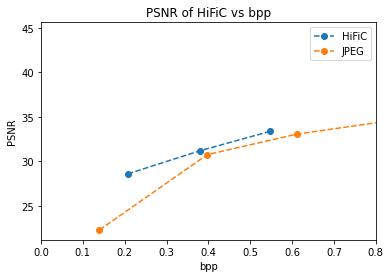

In [13]:
plt.plot(arr, psnr_hifi, '--o')
plt.xlabel('bpp')
plt.ylabel('PSNR')
plt.title('PSNR of HiFiC vs bpp')
plt.plot(num_bytes*8/(im.shape[0]*im.shape[1]), psnr_jpg, '--o')
plt.legend(['HiFiC', 'JPEG'])
plt.xlim([0,.8])

### Comparison of HiFiC and JPEG at $\approx$ .4 bpp

In [14]:
fp_hific = os.path.join(im_store_decomp, im_decomp_name.format("mi", start_ind))
fp_jpeg = os.path.join(im_store_dir_jpeg, im_jpg_name.format(start_ind, 20))

Text(0.5, 1.0, 'HiFiC Image at .4 bpp')

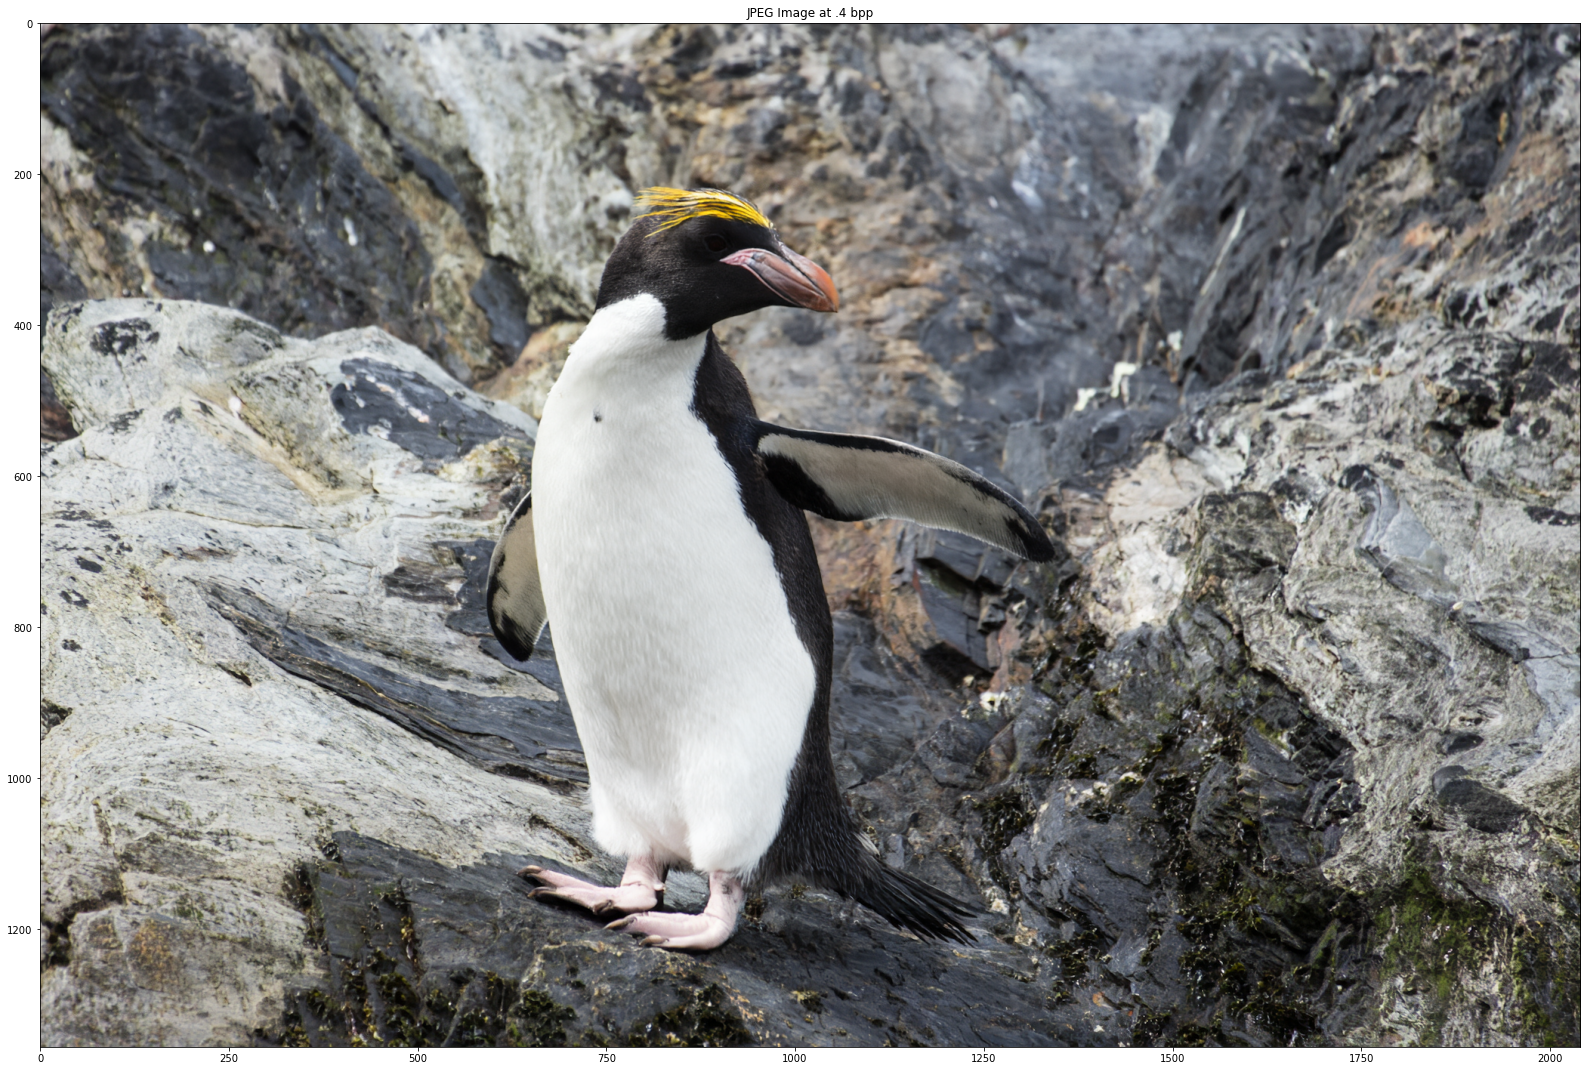

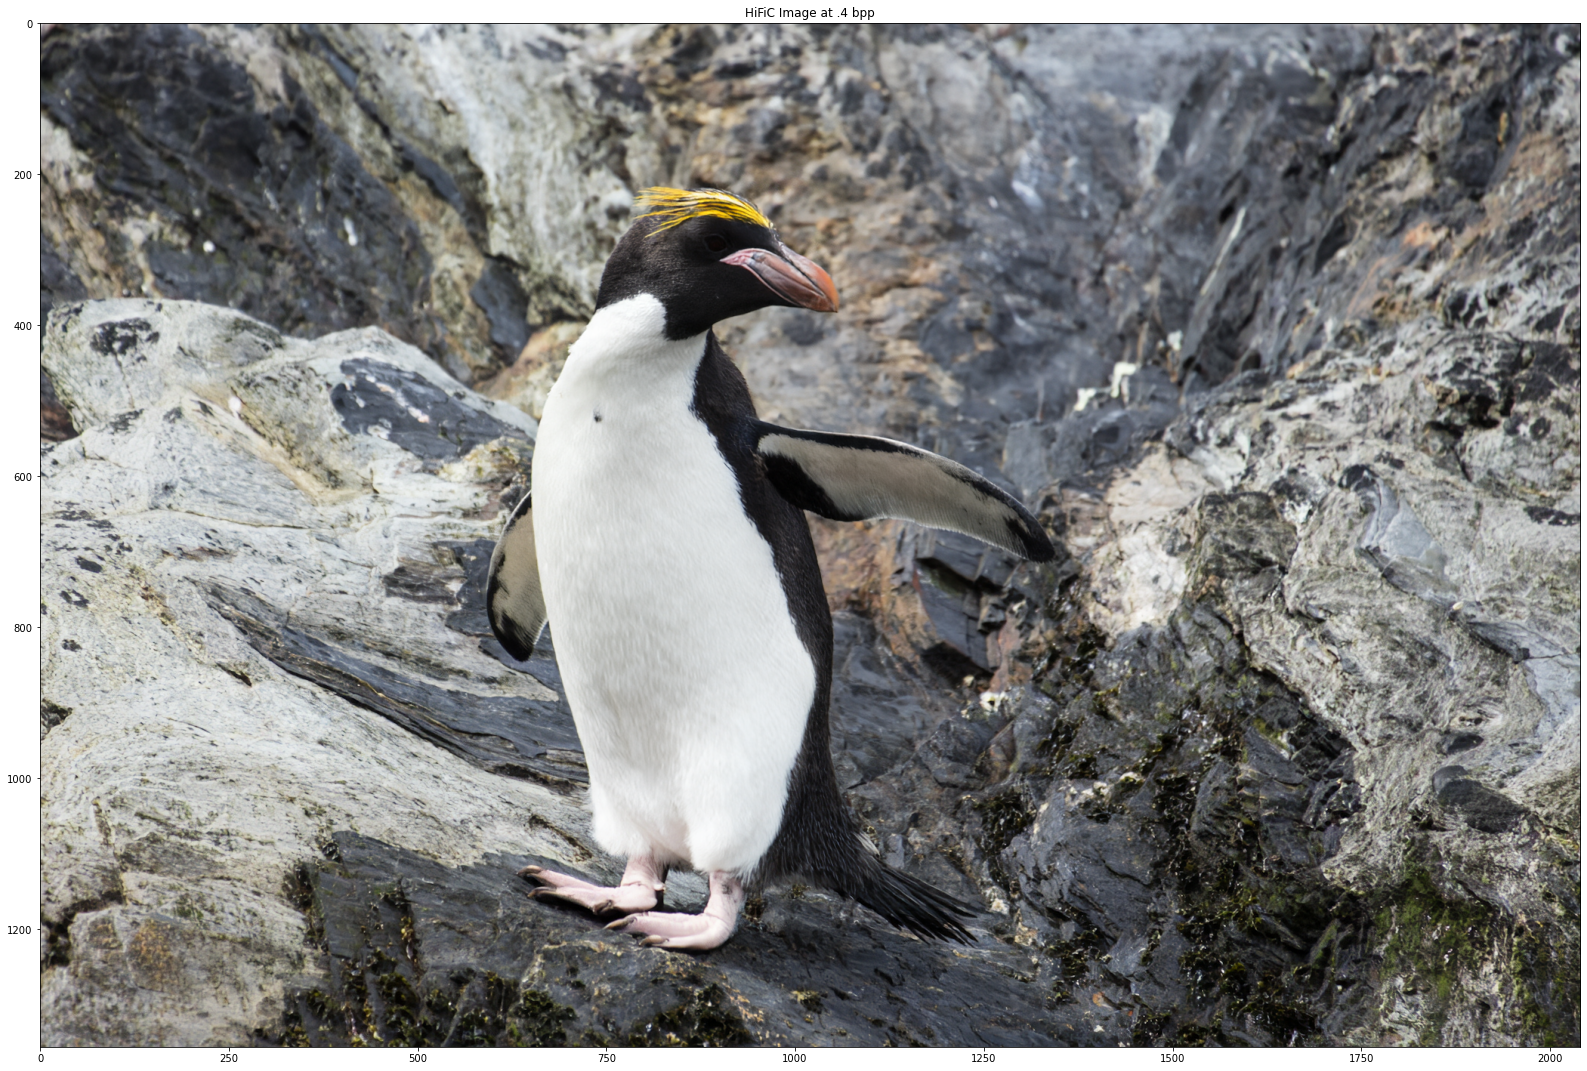

In [15]:
import matplotlib

dpi = matplotlib.rcParams['figure.dpi']

im_jpg = cv2.imread(fp_jpeg)[...,::-1]
im_hifi = cv2.imread(fp_hific)[...,::-1]

height_1, width_1, depth_1 = im_hifi.shape
figsize_1 = width_1 / float(dpi), height_1 / float(dpi)

plt.figure(figsize=figsize_1)

plt.imshow(im_hifi)
plt.title("JPEG Image at .4 bpp")

height_2, width_2, depth_2 = im_hifi.shape
figsize_2 = width_2 / float(dpi), height_2 / float(dpi)

plt.figure(figsize=figsize_2)

plt.imshow(im_hifi)
plt.title("HiFiC Image at .4 bpp")

To the human eye, there does not seem to be too much of a difference.